In [ ]:
import numpy as np

from glob import glob
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns

from PIL import Image
from skimage import io, color, img_as_float, img_as_ubyte
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import transforms
from torchvision.models import resnet50
from torchvision.datasets import ImageFolder

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

!pip install torchinfo
from torchinfo import summary

#
# grad-cam library 
# https://github.com/jacobgil/pytorch-grad-cam
#
!pip install grad-cam
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

!nvidia-smi

PyTorch Version:  1.7.1
Torchvision Version:  0.8.2
Tue Feb  7 14:46:38 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.34       Driver Version: 430.34       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:19:00.0 Off |                  N/A |
| 24%   35C    P8     3W / 250W |   3139MiB / 11019MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  Off  | 00000000:1A:00.0 Off |                  N/A |
| 24%   35C    P8     5W / 250W |     11MiB / 11019MiB |      0%      Default |
+-------------------------------+---

In [ ]:
!python --version

root_path = "/media/kondo/Ext4_for_Colab/tomizawa/paper/" #@param {type:"string"}
#@markdown  - Assign a path for your root directory. This root directory should include an image dataset directory ("/data/data_original/") and "/utils/" directory.
#@markdown  - The image dataset is available at a database (URL in #README on the GitHub).
#@markdown  - The library "utils" is available at the same GitHub page with this jupyter notebook.

%cd $root_path 
!pwd
!ls

Python 3.6.10 :: Anaconda, Inc.
/media/kondo/Ext4_for_Colab/tomizawa/paper
/media/kondo/Ext4_for_Colab/tomizawa/paper
data	   figures  results_old		 results_test
data_old1  results  results_randomLabel  utils


In [ ]:
from utils.loaders import Args, ImageTransform, MarchantiaDataset, MaskDataset, get_data, indices_to_loader
from utils.misc import get_unnormalize, get_datetime, makedirs, set_requires_grad_toFalse, train_model_pytorch_tutorial, compute_loss
from utils.misc import visualize_batch
from utils.misc import display_loss_acc, predict_testloader, test_loadedModel

from utils.cams import GradCAM_withGrad, calculate_cam, input_to_img
from utils.cams import get_cam_visualizations, get_cam_visualizations_withGrad, plot_cam_results, plot_gradients_activations
from utils.camCondition import CamConditionContainer

In [ ]:
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(dev)

cuda


Dataset ImageFolder
    Number of datapoints: 200
    Root location: ./data/data_original/Tak/0d
{'Tak-1_0d_M': 0, 'Tak-2_0d_F': 1}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


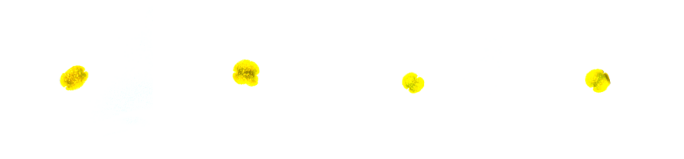

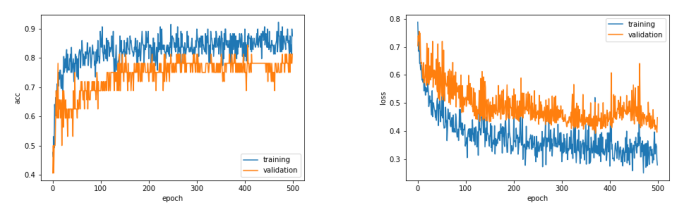

epoch with max validation acc. : 406
loss : 0.44066745042800903, acc : 0.84375
Dataset ImageFolder
    Number of datapoints: 600
    Root location: ./data/data_original/RIL5/0d
{'RIL5_0d_F': 0, 'RIL5_0d_M': 1}
(600,)
acc :  0.49833333333333335
Number of classified as Tak-1 (Male) :  243
Number of classified as Tak-2 (Female) :  357


,true_label,pred_label,correct,category,N_samples
0,M,M,True,trueM-predM,121
0,M,F,False,trueM-predF,179
0,F,M,False,trueF-predM,122
0,F,F,True,trueF-predF,178


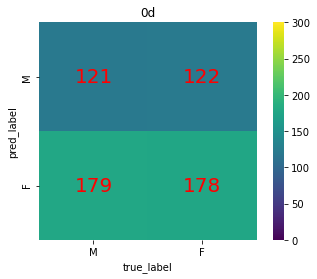

Dataset ImageFolder
    Number of datapoints: 200
    Root location: ./data/data_original/Tak/1d
{'Tak-1_1d_M': 0, 'Tak-2_1d_F': 1}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


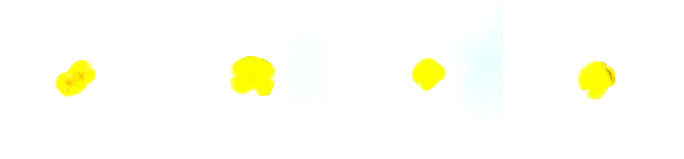

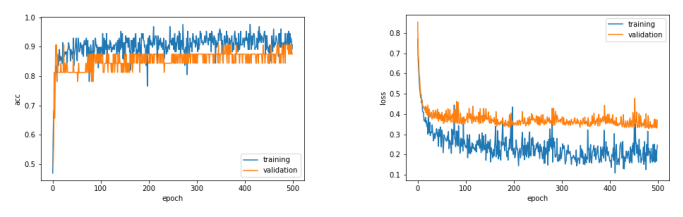

epoch with max validation acc. : 6
loss : 0.504274308681488, acc : 0.90625
Dataset ImageFolder
    Number of datapoints: 600
    Root location: ./data/data_original/RIL5/1d
{'RIL5_1d_F': 0, 'RIL5_1d_M': 1}
(600,)
acc :  0.48
Number of classified as Tak-1 (Male) :  296
Number of classified as Tak-2 (Female) :  304


,true_label,pred_label,correct,category,N_samples
0,M,M,True,trueM-predM,142
0,M,F,False,trueM-predF,158
0,F,M,False,trueF-predM,154
0,F,F,True,trueF-predF,146


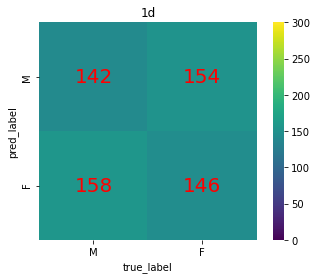

Dataset ImageFolder
    Number of datapoints: 200
    Root location: ./data/data_original/Tak/2d
{'Tak-1_2d_M': 0, 'Tak-2_2d_F': 1}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


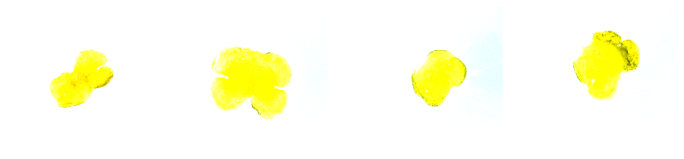

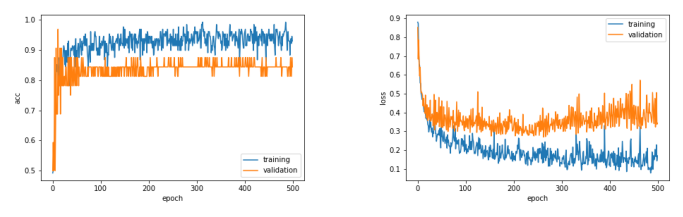

epoch with max validation acc. : 11
loss : 0.43509024381637573, acc : 0.96875
Dataset ImageFolder
    Number of datapoints: 600
    Root location: ./data/data_original/RIL5/2d
{'RIL5_2d_F': 0, 'RIL5_2d_M': 1}
(600,)
acc :  0.47333333333333333
Number of classified as Tak-1 (Male) :  566
Number of classified as Tak-2 (Female) :  34


,true_label,pred_label,correct,category,N_samples
0,M,M,True,trueM-predM,275
0,M,F,False,trueM-predF,25
0,F,M,False,trueF-predM,291
0,F,F,True,trueF-predF,9


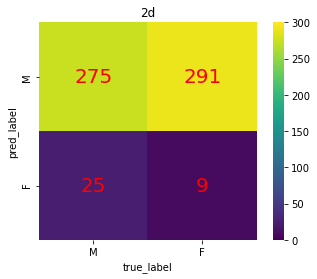

Dataset ImageFolder
    Number of datapoints: 200
    Root location: ./data/data_original/Tak/3d
{'Tak-1_3d_M': 0, 'Tak-2_3d_F': 1}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


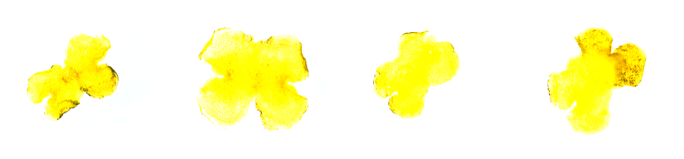

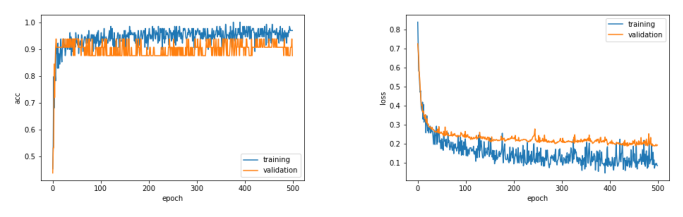

epoch with max validation acc. : 7
loss : 0.42028388381004333, acc : 0.9375
Dataset ImageFolder
    Number of datapoints: 602
    Root location: ./data/data_original/RIL5/3d
{'RIL5_3d_F': 0, 'RIL5_3d_M': 1}
(602,)
acc :  0.5099667774086378
Number of classified as Tak-1 (Male) :  522
Number of classified as Tak-2 (Female) :  80


,true_label,pred_label,correct,category,N_samples
0,M,M,True,trueM-predM,264
0,M,F,False,trueM-predF,37
0,F,M,False,trueF-predM,258
0,F,F,True,trueF-predF,43


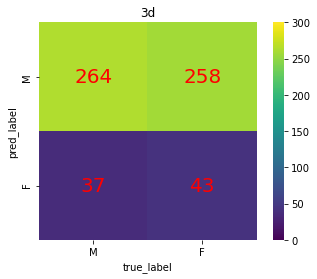

Dataset ImageFolder
    Number of datapoints: 200
    Root location: ./data/data_original/Tak/4d
{'Tak-1_4d_M': 0, 'Tak-2_4d_F': 1}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


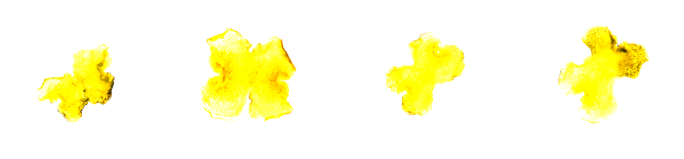

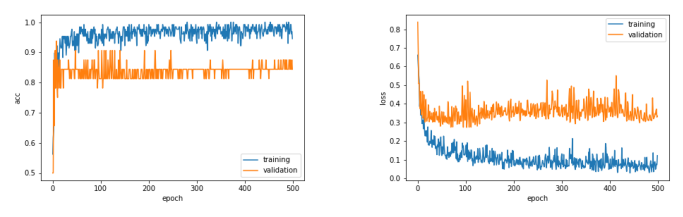

epoch with max validation acc. : 8
loss : 0.3406580984592438, acc : 0.9375
Dataset ImageFolder
    Number of datapoints: 600
    Root location: ./data/data_original/RIL5/4d
{'RIL5_4d_F': 0, 'RIL5_4d_M': 1}
(600,)
acc :  0.5116666666666667
Number of classified as Tak-1 (Male) :  311
Number of classified as Tak-2 (Female) :  289


,true_label,pred_label,correct,category,N_samples
0,M,M,True,trueM-predM,159
0,M,F,False,trueM-predF,141
0,F,M,False,trueF-predM,152
0,F,F,True,trueF-predF,148


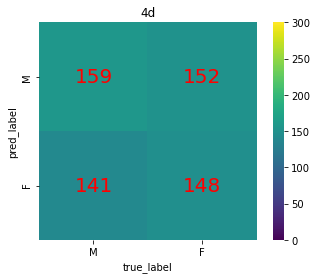

Dataset ImageFolder
    Number of datapoints: 200
    Root location: ./data/data_original/Tak/7d
{'Tak-1_7d_M': 0, 'Tak-2_7d_F': 1}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


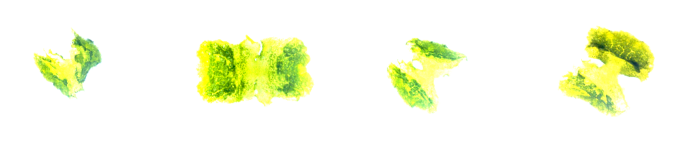

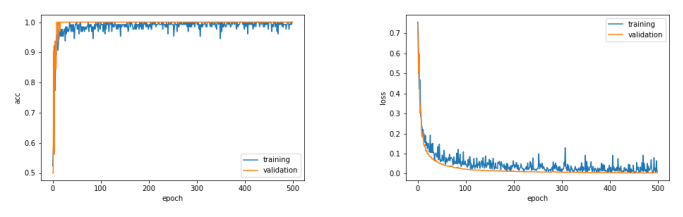

epoch with max validation acc. : 8
loss : 0.1965215802192688, acc : 1.0
Dataset ImageFolder
    Number of datapoints: 600
    Root location: ./data/data_original/RIL5/7d
{'RIL5_7d_F': 0, 'RIL5_7d_M': 1}
(600,)
acc :  0.5566666666666666
Number of classified as Tak-1 (Male) :  468
Number of classified as Tak-2 (Female) :  132


,true_label,pred_label,correct,category,N_samples
0,M,M,True,trueM-predM,251
0,M,F,False,trueM-predF,49
0,F,M,False,trueF-predM,217
0,F,F,True,trueF-predF,83


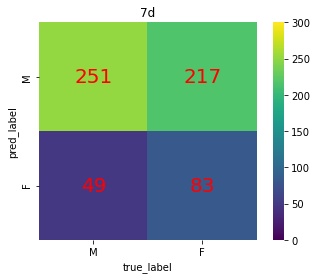

In [ ]:
def get_args(strain, day, ablation, multilabel=False):
  args = Args()
  args.root =  './data/data_' + ablation + '/' + strain + '/' + day

  ### model
  model_path = glob('./results_forGitHub/*' + strain + '_' + day + '*/') if(multilabel==False)&(ablation=='original_noScaleBar')  else None
  model_path.sort()
  model_path = model_path[0]
  args.model_path = model_path
  args.model_fname = glob(args.model_path + '*.pt')[0]
  return args


strain_list = ['Tak']
day_list = ['0d', '1d', '2d', '3d', '4d', '7d']
ablation_list = ['original_noScaleBar']
multilabel=False

results_dname = './figures/forGitHub/Tak-classifier_RIL5-data/'
makedirs(results_dname)

df = pd.DataFrame()
# for strain in strain_list:
for ablation in ablation_list:
  for day in day_list:
      args = get_args('Tak', day, ablation, multilabel)
      # print(args.__dict__)
      ## load a model
      model = resnet50(pretrained=False)
      num_ftrs = model.fc.in_features
      model.fc = nn.Linear(num_ftrs, 2)
      model.load_state_dict(torch.load(args.model_fname, map_location=torch.device('cpu')))
      model.to(dev);

      ## load a dataset ('Tak')
      Transform = ImageTransform(fill=255)
      full_dataset = ImageFolder(root=args.root)
      print(full_dataset)
      print(full_dataset.class_to_idx)
      dataset_noaug = MarchantiaDataset(full_dataset, Transform.data_transform["valid"])
      val_loader = indices_to_loader(args.model_path, 'indices_val.csv', dataset_noaug, batch_size=args.batch_size)
      test_loader = indices_to_loader(args.model_path, 'indices_test.csv', dataset_noaug, batch_size=args.batch_size)
      test_images, _ = next(iter(test_loader))
      visualize_batch(test_images); plt.show()

      display_loss_acc(args.model_path); plt.show()
      test_loadedModel(args.model_path, model, val_loader, dev, multilabel=multilabel)
      

      ## Note that Tak-1/Tak-2 labels are inverted from RIL5 and Aus due to different naming of accession
      ## Tak M : 0, F: 1 ←→ RIL5 F : 0, M: 1

      ## load RIL5 dataset
      data_path_RIL5 =  './data/data_' + ablation + '/' + 'RIL5' + '/' + day
      # dataset_RIL5
      full_dataset_RIL5 = ImageFolder(root=data_path_RIL5)
      print(full_dataset_RIL5)
      print(full_dataset_RIL5.class_to_idx)


      dataset_RIL5 = MarchantiaDataset(full_dataset_RIL5, Transform.data_transform["valid"])
      dataloader_RIL5 = data.DataLoader(dataset_RIL5, batch_size=args.batch_size, shuffle= True)
      inputs_test, labels_test, outputs_test, preds_test = predict_testloader(model, dataloader_RIL5, dev)
      print(preds_test.shape)
      # print(labels_test)
      inverted_labels = (labels_test -1)*(-1) #RIL5 teacher labels。invert label to match Tak-1/Tak-2 into 'Male': 0, 'Female': 1
      # print('preds, ', preds_test)
      print('acc : ', preds_test[preds_test == inverted_labels].shape[0]/preds_test.shape[0])
      print('Number of classified as Tak-1 (Male) : ', preds_test[preds_test == 0].shape[0])
      print('Number of classified as Tak-2 (Female) : ', preds_test[preds_test == 1].shape[0])

      ### plot
      df = pd.DataFrame()
      class_dict = {'M':0, 'F':1}
      for true_label in ['M', 'F']:
        tmp = preds_test[inverted_labels==class_dict[true_label]] ## preds > correct prediction
        for pred_label in ['M', 'F']:
          N_samples = tmp[tmp==class_dict[pred_label]].shape ## extract predicted label
          correct_bool = true_label == pred_label
          # print('true_label: ', true_label, ', pred_label: ', pred_label, ', correct: ', correct_bool, N_samples)
          df_tmp = pd.DataFrame(data={'true_label': [true_label], 
                                      'pred_label': [pred_label],
                                      'correct': [correct_bool],
                                      'category' : ['true'+true_label + '-pred' + pred_label],
                                      'N_samples': [N_samples[0]]})
          df = pd.concat([df, df_tmp])
      display(df)

      df_pivot = df.pivot('pred_label', 'true_label', 'N_samples')
      df_pivot = df_pivot.reindex(['M', 'F'], axis=0)
      df_pivot = df_pivot.reindex(['M', 'F'], axis=1)

      sns.heatmap(df_pivot,
                  vmin=0, vmax=300,
                  square=True, cmap='viridis',
                  annot=True, fmt='.3g', annot_kws={'size':20, 'color':'red'},
                  )
      plt.title(day)
      plt.savefig(results_dname + day + '.pdf', dpi=300)
      plt.savefig(results_dname + day + '.png', dpi=300)
      plt.show()
